In [1]:
import torch.nn as nn
from torchvision import models
from Dataset import *
import torch.nn.functional as F
import torch

In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:
DATASET = r'E:\Thesis_Final\A2D2_dataset'
IMG_DIR = DATASET + "/images/"
LABEL_DIR = DATASET + "/A2D2_3D_Obj_det_label_txt/"
CSV_Path= DATASET+ "/subset2.csv"

## Dataloading

In [4]:
dataset = A2D2_3D_det_Dataset(image_dir= IMG_DIR, label_dir= LABEL_DIR, csv_file= CSV_Path,transform= None)
print(len(dataset))
print(dataset[0].image.shape)

98
(3, 304, 480)


## Visualization

In [111]:
def draw_2d_box(im, box, color=(0, 200, 200), thickness=2):

    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    x2 =(x + w) - 1
    y2 = (y + h) - 1

    cv2.rectangle(im, (int(x),int(y)), (int(x2),int(y2)), color, thickness)
    #plt.imshow(im)
def draw_3d_box(im, verts, color=(0, 200, 150), thickness=1):

    for lind in range(0, verts.shape[0] - 1):
        v1 = (verts[lind])*0.25
        v2 = (verts[lind + 1])*0.25
        cv2.line(im, (int(v1[0]), int(v1[1])), (int(v2[0]), int(v2[1])), color, thickness)
    #plt.imshow(im)
def draw_circle(im, pos, radius=5, thickness=5, color=(0, 150, 200), fill=False):

    if fill: thickness = -1

    cv2.circle(im, (int(pos[0]), int(pos[1])), radius, color=color, thickness=thickness)
    #plt.imshow(im)
def draw_bev(axis_bev, z3d, l3d, w3d, x3d, ry3d, color=(0, 200, 200), scale=100, thickness=2):
    """
    w = l3d * scale
    print('W',w)
    l = w3d * scale
    print('L',l)
    x = x3d * scale
    print('X',x)
    z = z3d * scale
    print('Z',z)
    r = ry3d*-1
    #r= ry3d

    corners1 = np.array([
        [-w / 2, -l / 2, 1],
        [+w / 2, -l / 2, 1],
        [+w / 2, +l / 2, 1],
        [-w / 2, +l / 2, 1]
    ])
    """
    l = l3d * scale
    
    w = w3d * scale
    #print('W',w)
    #print('L',l)
    x = x3d * scale
    #print('X',x)
    z = z3d * scale
    #print('Z',z)
    #r = ry3d*-1
    r= ry3d

    corners1 = np.array([
        [-l / 2, -w / 2, 1],
        [+l / 2, -w / 2, 1],
        [+l / 2, +w / 2, 1],
        [-l/ 2, +w / 2, 1]
           ])
    ry = np.array([
        [+math.cos(r), -math.sin(r), 0],
        [+math.sin(r), math.cos(r), 0],
        [0, 0, 1],
    ])

    rz = np.array([
        [+math.cos(r),0, +math.sin(r)],[0,1,0],
        [-math.sin(r),0, +math.cos(r)]
    ])

    corners2 = ry.dot(corners1.T).T
    
    #corners2[:, 0] += w/2 + x 
    #corners2[:, 1] += l/2 + z + canvas_bev.shape[0] /2
    corners2[:, 0] += l/2+ x 
    corners2[:, 1] += w/2 + z 

    corners_f= corners2[:,:2]

    x_corners= []
    y_corners= []
    for i in range(corners_f.shape[0]):
        x_corners.append(corners_f[i,0])
        y_corners.append(corners_f[i,1])
    x_corners.append(x_corners[0])
    y_corners.append(y_corners[0])
    x_corners= np.array(x_corners)
    y_corners= np.array(y_corners)
    axis_bev.plot(-y_corners,x_corners)
    axis_bev.arrow(0,0,0,2,head_width=1, head_length=1)
    return axis_bev
def draw_line(im, v1, v2, color=(0, 0, 200), thickness=10):
    #v1= v1*0.25
    #v2= v2*0.25
    cv2.line(im, (int(v1[0]), int(v1[1])), (int(v2[0]), int(v2[1])), color, thickness)

In [112]:
def project_3d(p2, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, return_3d=False):
    """
    Projects a 3D box into 2D vertices
    Args:
        p2 (nparray): projection matrix of size 4x3
        x3d: x-coordinate of center of object
        y3d: y-coordinate of center of object
        z3d: z-cordinate of center of object
        w3d: width of object
        h3d: height of object
        l3d: length of object
        ry3d: rotation w.r.t y-axis
    """

    # compute rotational matrix around yaw axis
    
    R = np.array([[+math.cos(ry3d), 0, +math.sin(ry3d)],
                  [0, 1, 0],
                  [-math.sin(ry3d), 0, +math.cos(ry3d)]])
    
    R1= np.array([[+math.cos(ry3d), -math.sin(ry3d),0],
                  
                  [+math.sin(ry3d), +math.cos(ry3d),0],[0, 0,1]])
    # 3D bounding box corners
    x_corners = np.array([0, l3d, l3d, l3d, l3d,   0,   0,   0])
    y_corners = np.array([0, 0,   h3d, h3d,   0,   0, h3d, h3d])
    z_corners = np.array([0, 0,     0, w3d, w3d, w3d, w3d,   0])

    x_corners += -l3d / 2
    y_corners += -h3d / 2
    z_corners += -w3d / 2

    # bounding box in object co-ordinate
    corners_3d = np.array([x_corners, y_corners, z_corners])
    
    # rotate
    #corners_3d = R.dot(corners_3d)
    corners_3d= R1.dot(corners_3d)
    # translate
    corners_3d += np.array([x3d, y3d, z3d]).reshape((3, 1))
    
    corners_3D_1 = np.vstack((corners_3d, np.ones((corners_3d.shape[-1]))))
    
    #corners_2D = p2.dot(corners_3D_1)
    corners_2D= np.matmul(p2,corners_3D_1)
    corners_2D= np.squeeze(corners_2D)
    corners_2D = corners_2D / corners_2D[2,:]
    #corners_2D= np.divide(corners_2D.T, (corners_2D[2,:]).T)
    #print("corners_2D",corners_2D)
    bb3d_lines_verts_idx = [0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 4, 1, 2, 7, 6, 3]

    verts3d = (corners_2D[:, bb3d_lines_verts_idx][:2]).T

    if return_3d:
        return verts3d, corners_3d
    else:
        return verts3d


In [113]:
from matplotlib import transforms as transform

k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11
k 12
k 13
k 14
k 15
k 16
k 17
k 18
k 19
k 20


C:\Users\I009809\AppData\Local\Temp\ipykernel_20288\2412025123.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig= plt.figure()


k 21
k 22
k 23
k 24
k 25
k 26
k 27
k 28
k 29
k 30
k 31
k 32
k 33
k 34
k 35
k 36
k 37
k 38
k 39
k 40
k 41
k 42
k 43
k 44
k 45
k 46
k 47
k 48
k 49
k 50
k 51
k 52
k 53
k 54
k 55
k 56
k 57
k 58
k 59
k 60
k 61
k 62
k 63
k 64
k 65
k 66
k 67
k 68
k 69
k 70
k 71
k 72
k 73
k 74
k 75
k 76
k 77
k 78
k 79
k 80
k 81
k 82
k 83
k 84
k 85
k 86
k 87
k 88
k 89
k 90
k 91
k 92
k 93
k 94
k 95
k 96
k 97


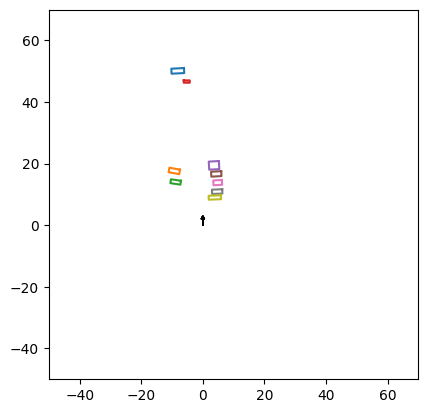

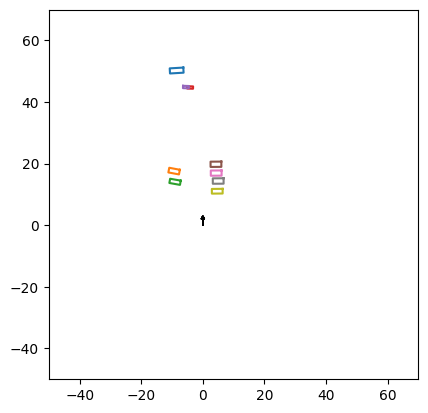

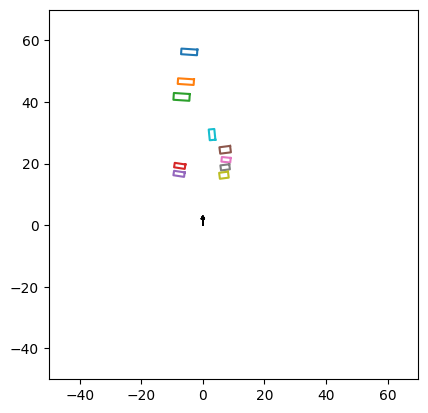

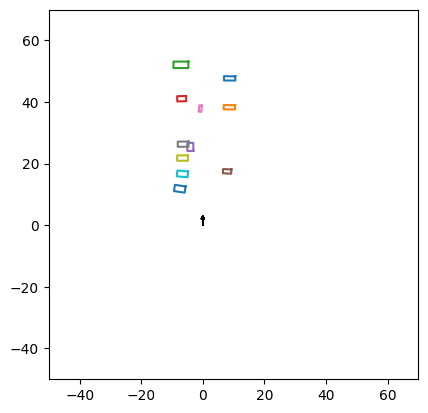

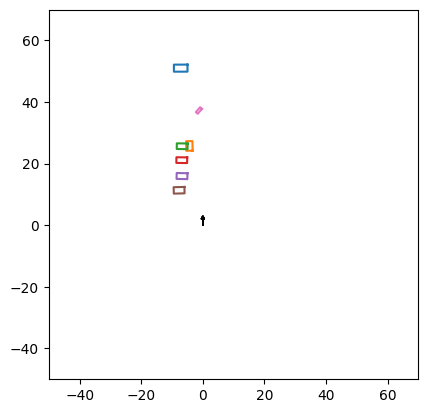

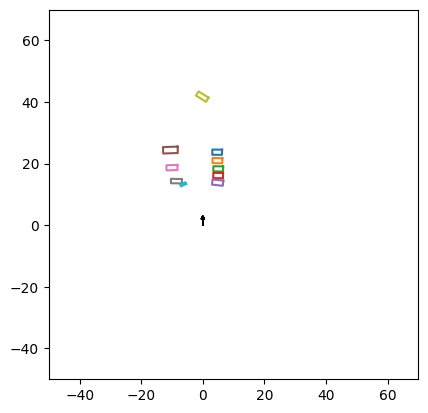

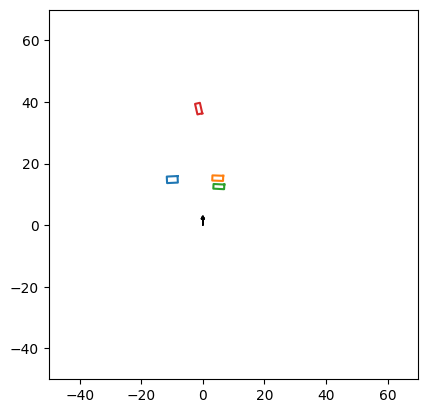

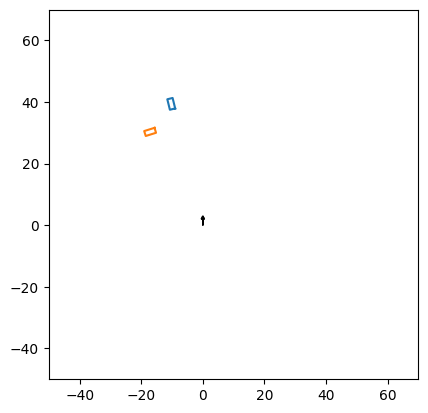

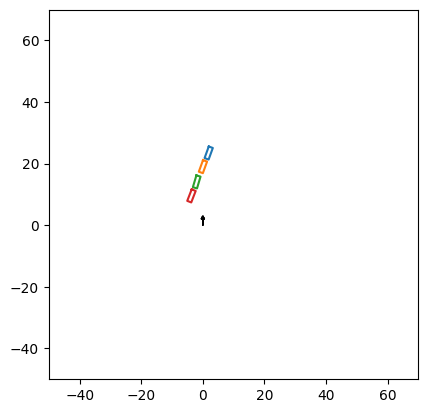

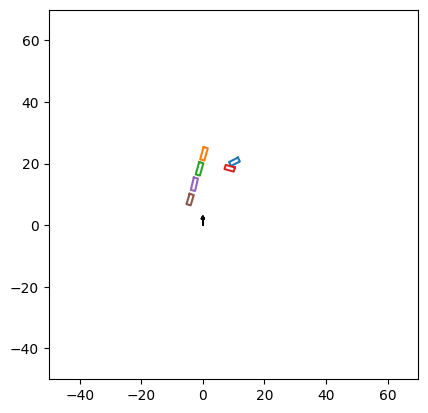

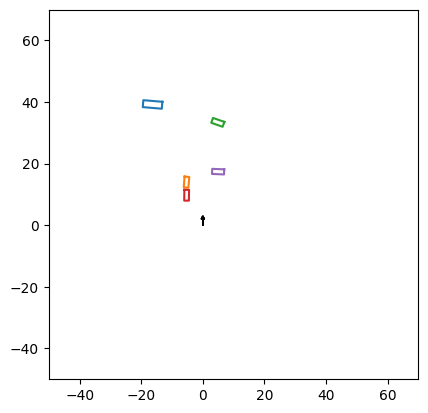

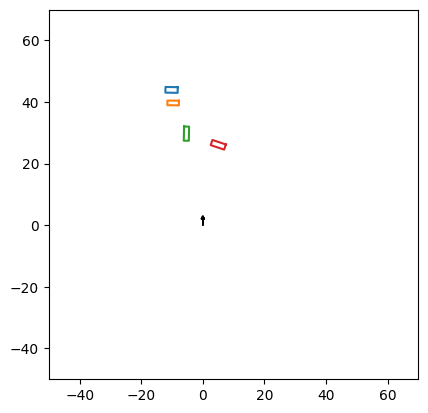

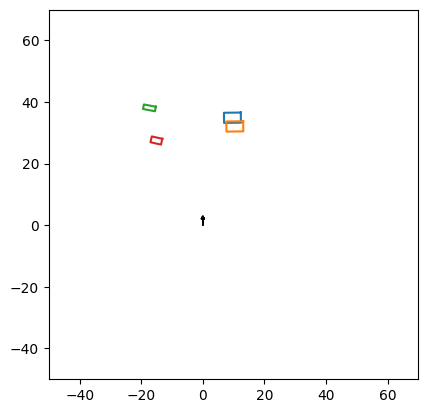

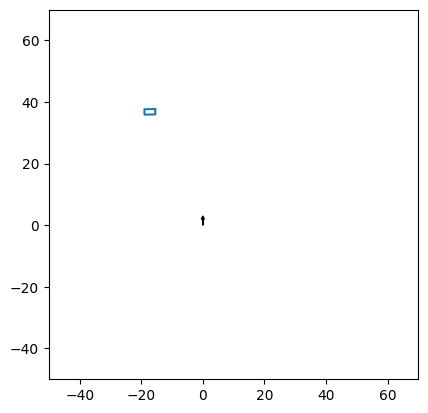

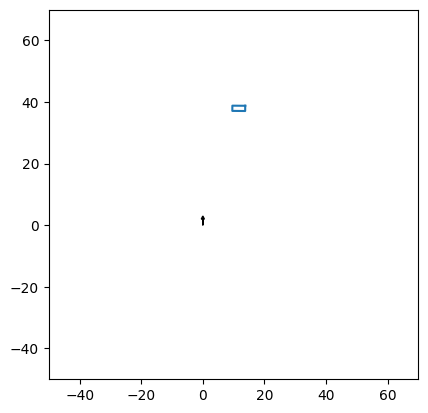

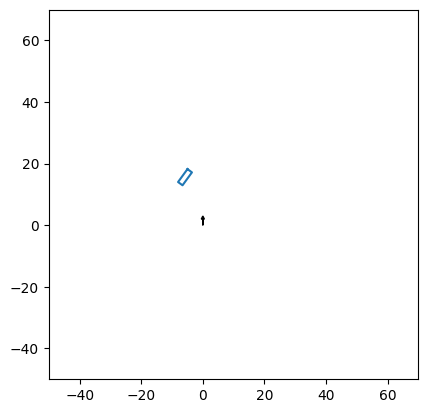

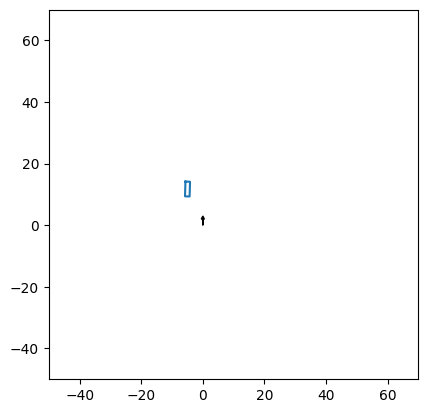

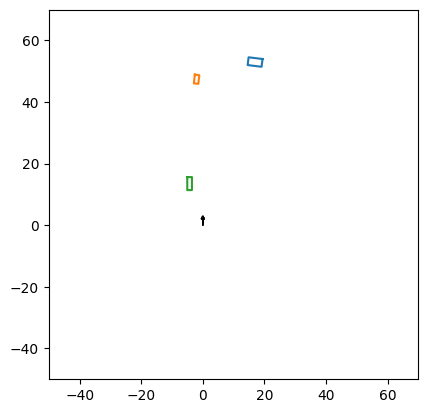

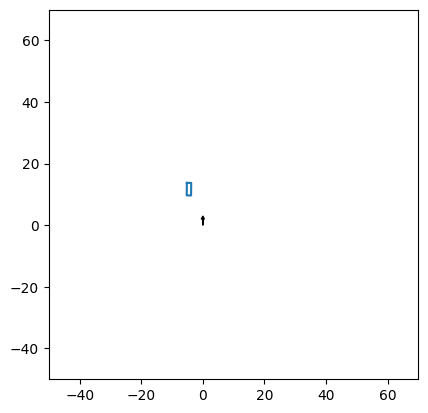

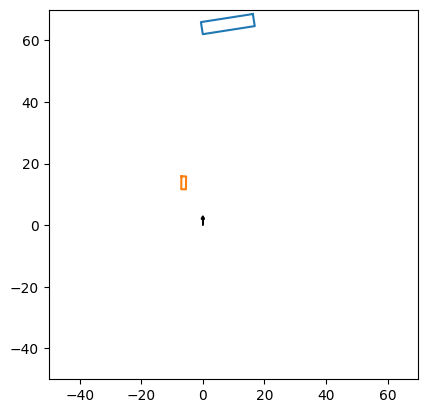

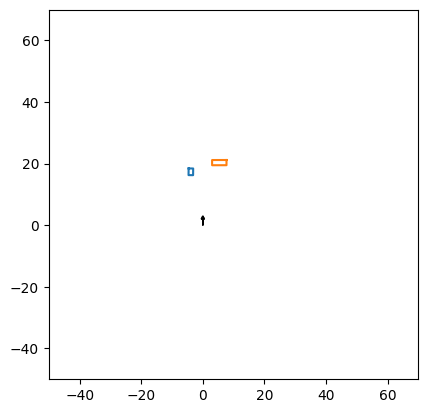

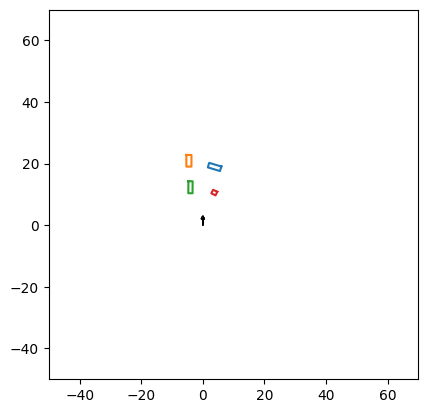

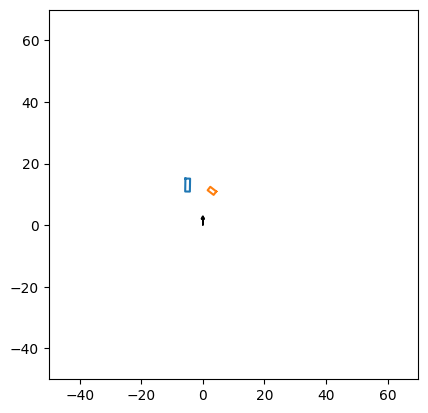

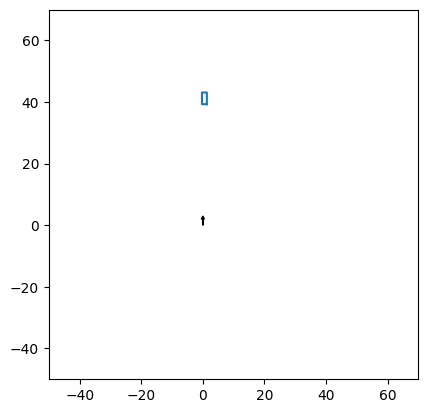

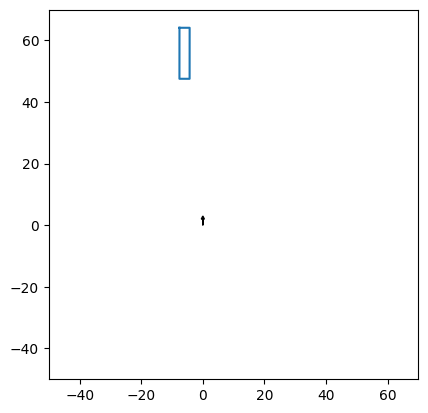

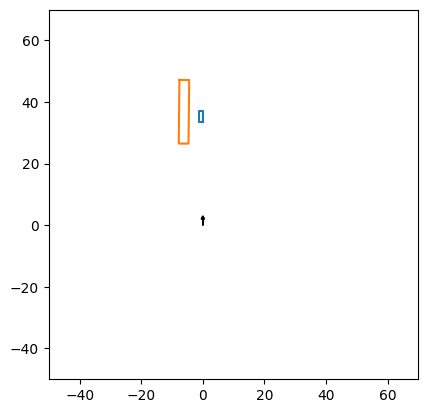

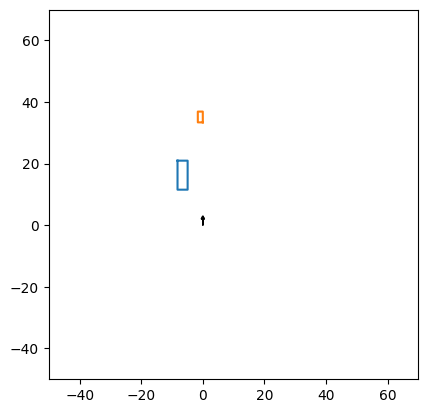

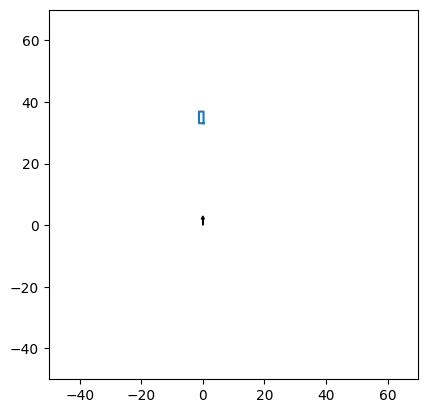

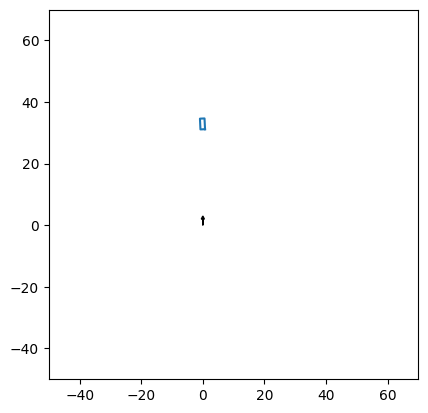

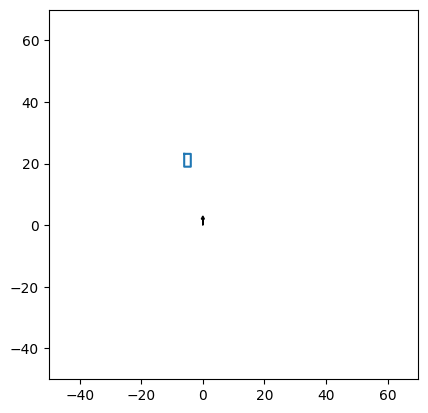

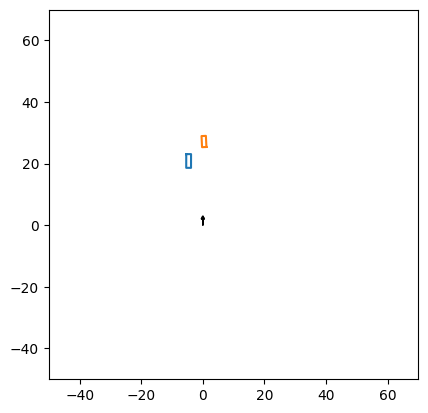

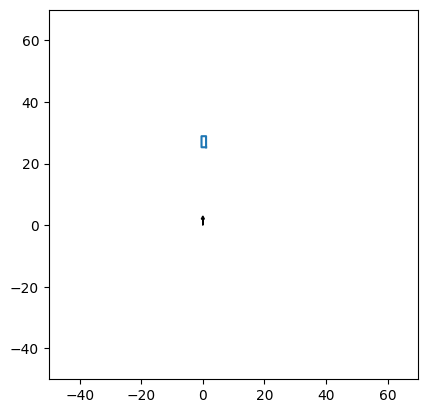

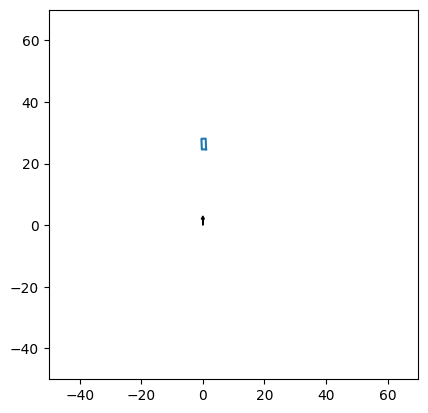

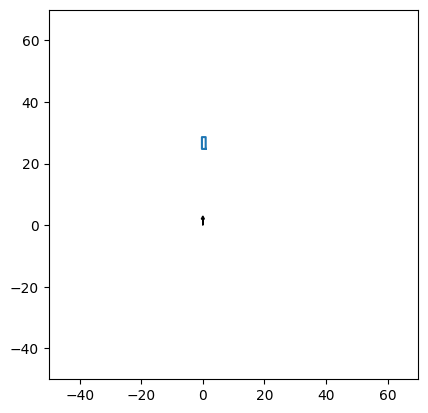

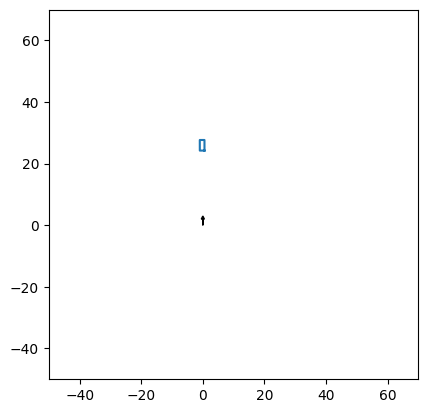

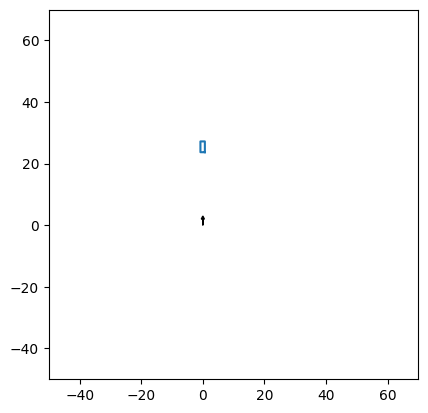

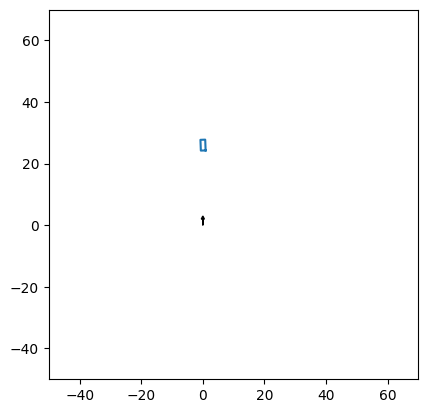

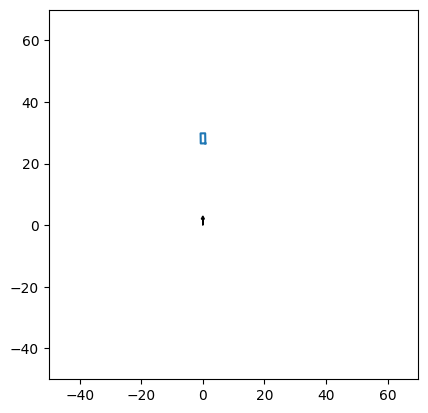

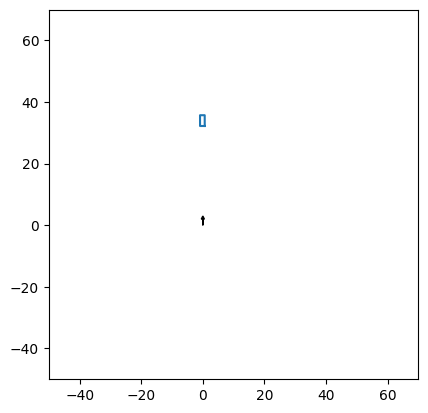

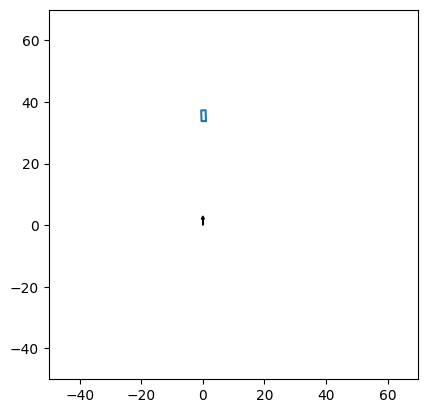

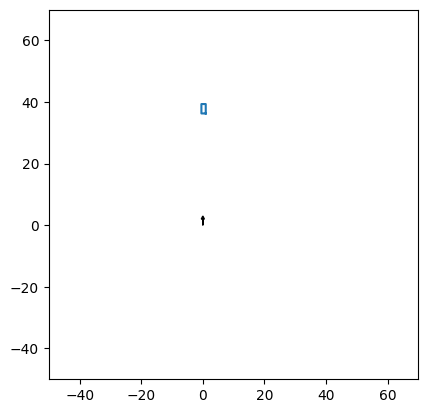

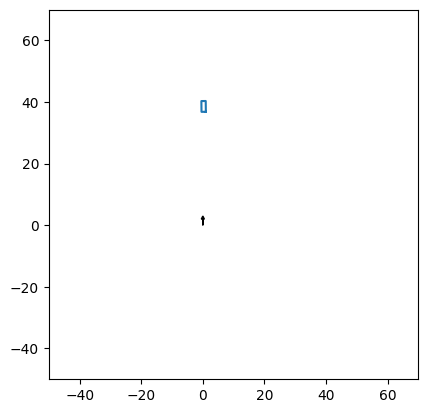

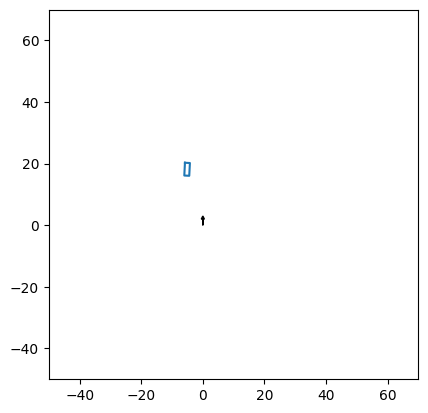

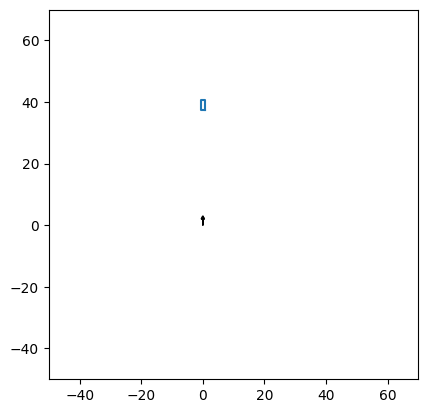

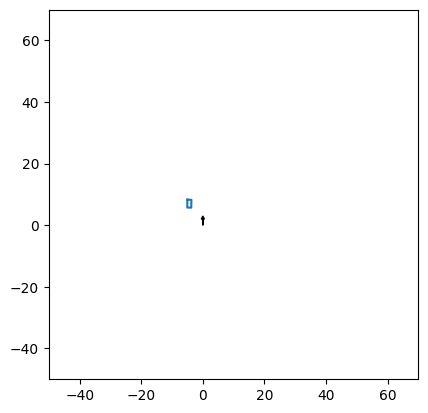

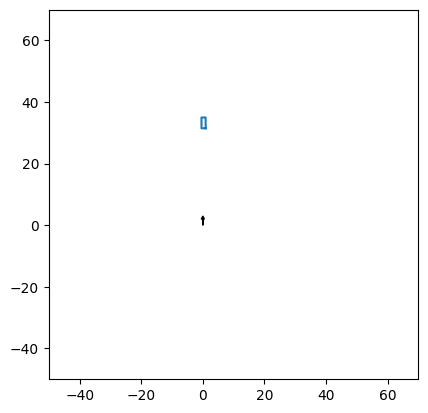

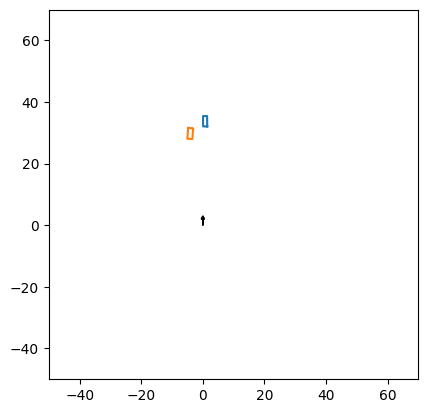

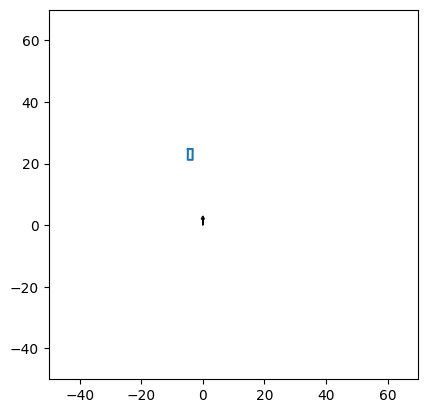

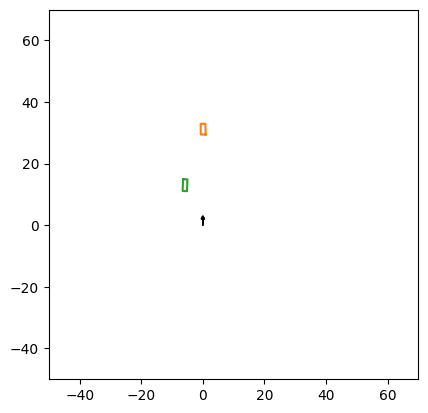

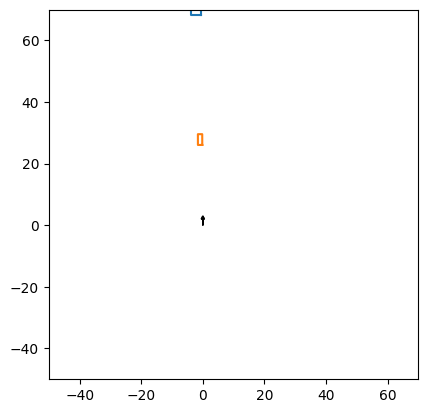

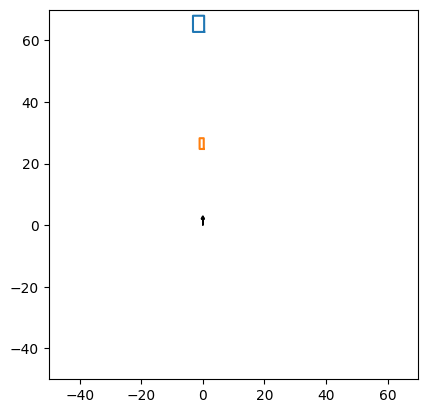

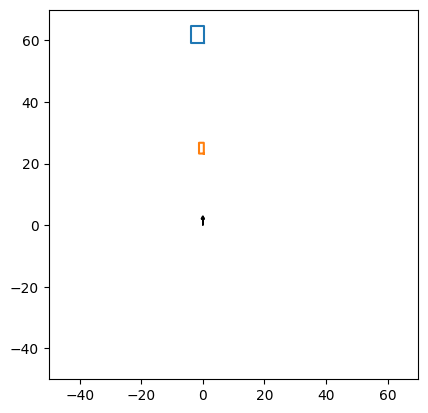

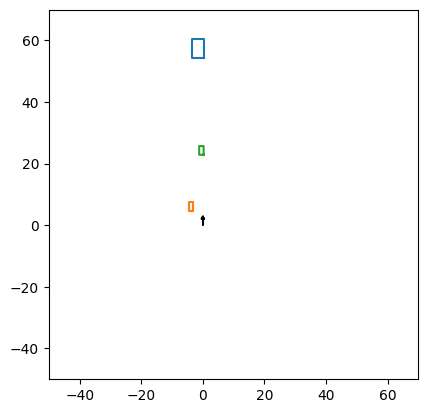

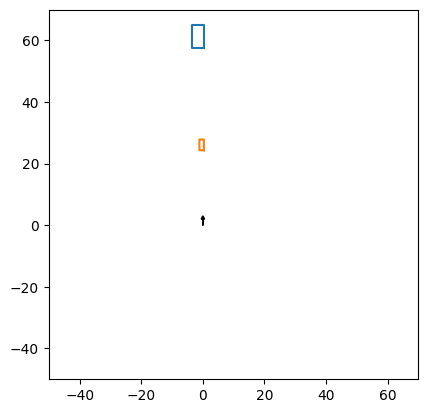

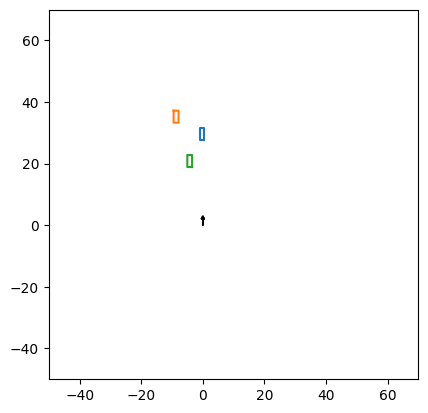

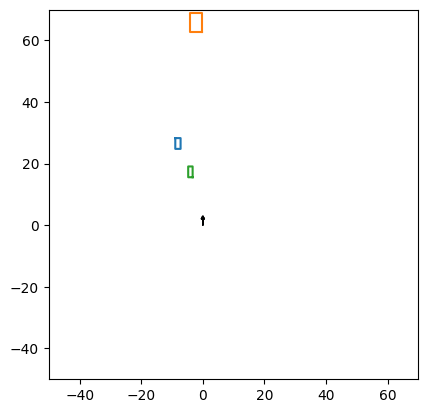

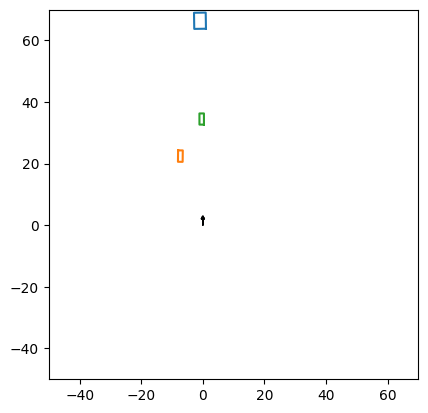

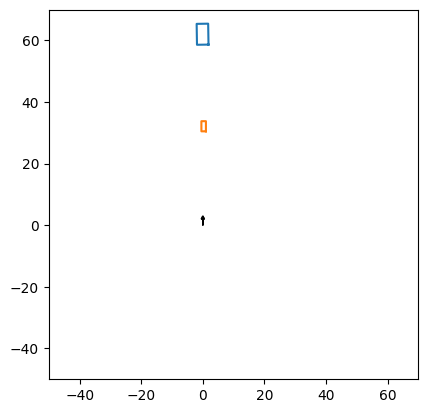

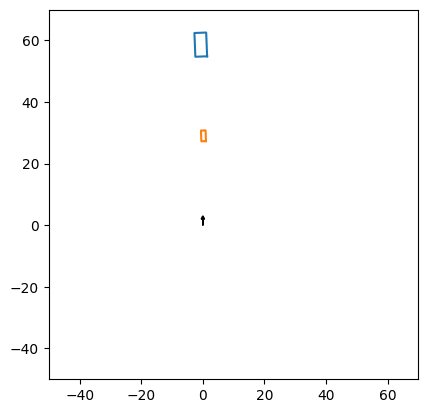

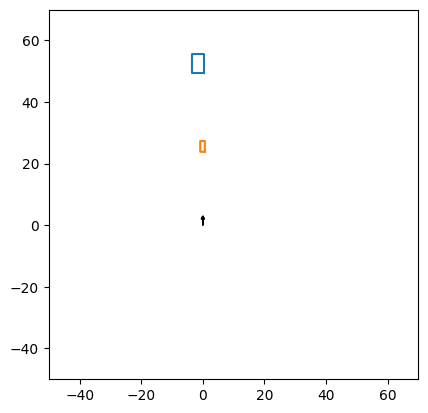

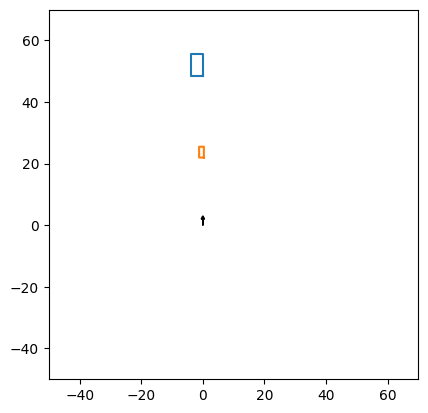

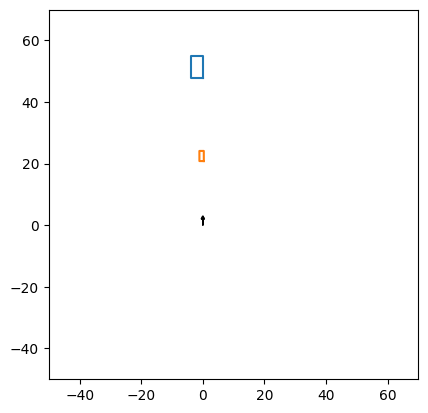

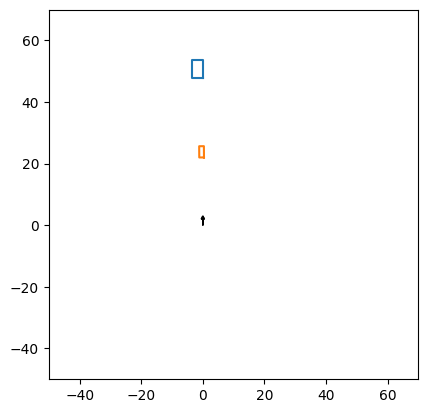

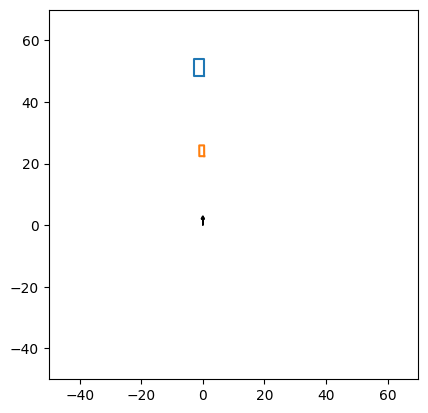

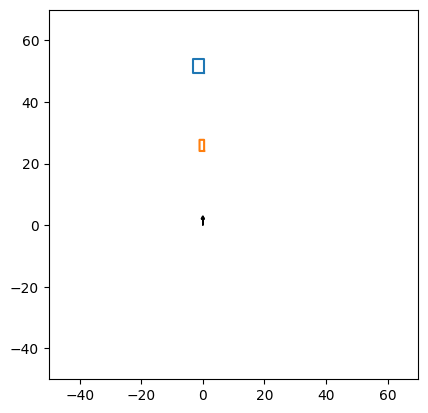

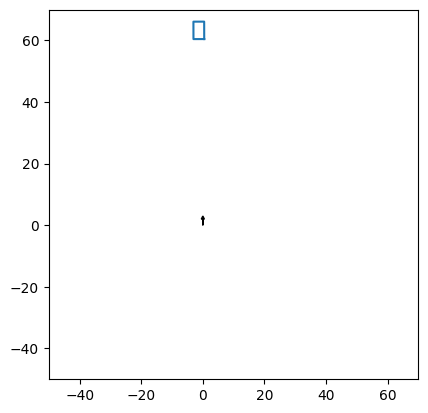

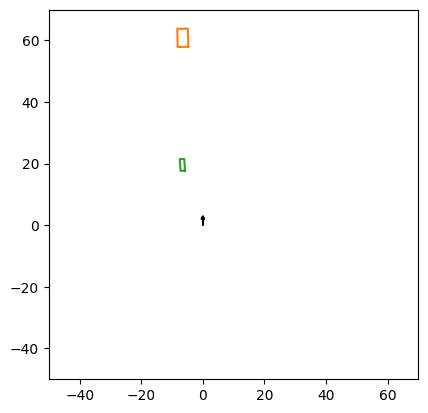

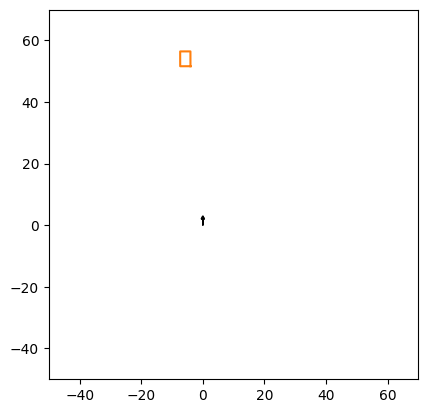

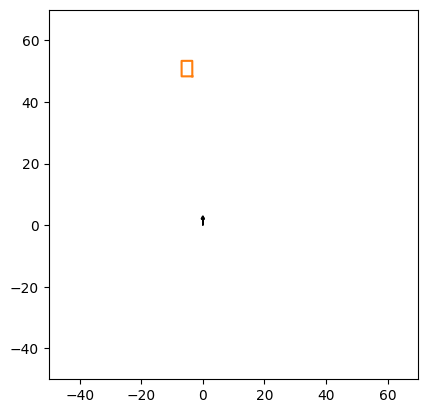

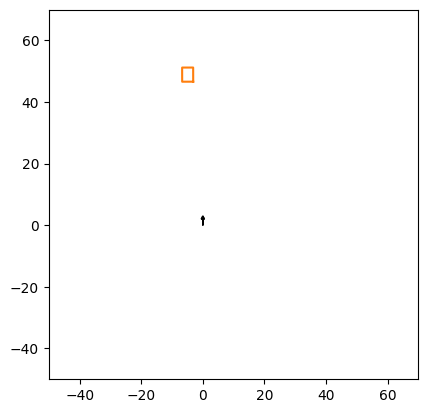

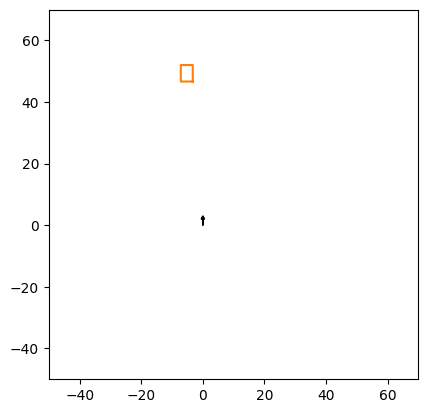

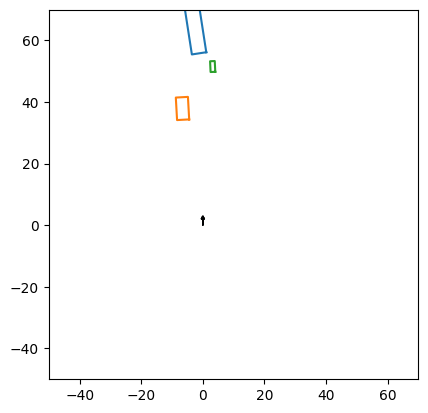

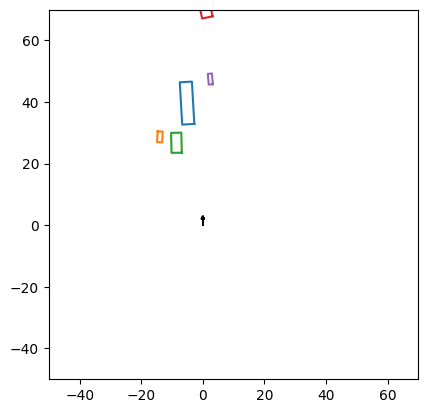

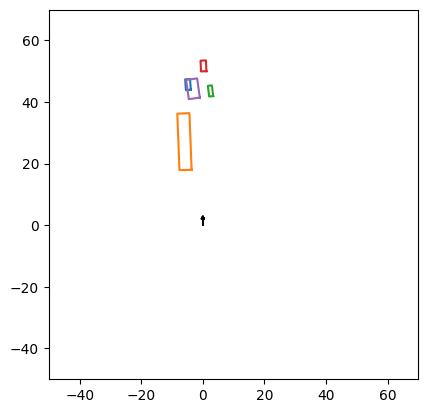

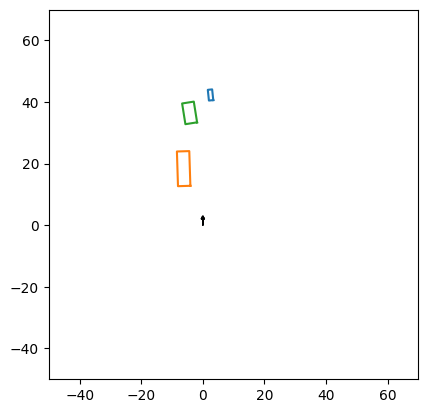

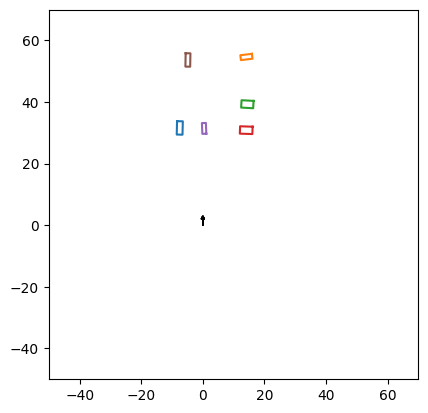

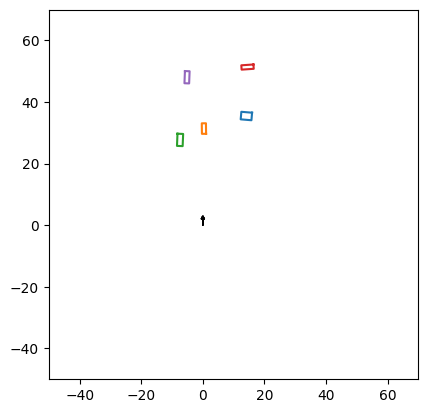

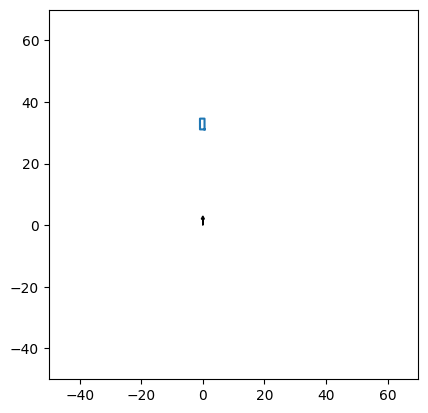

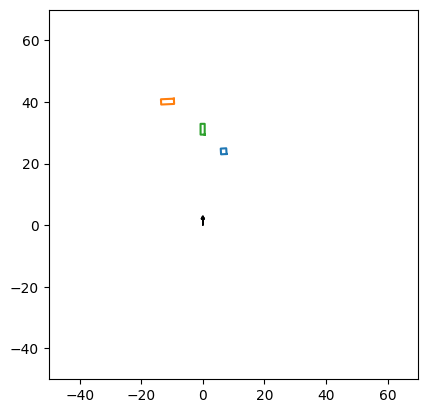

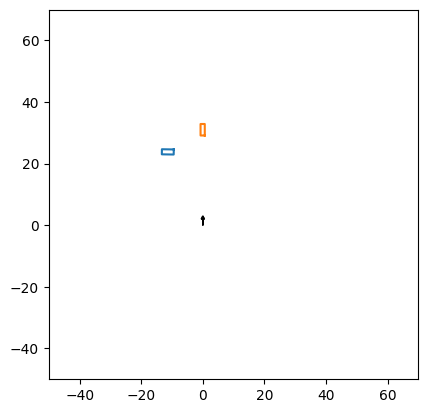

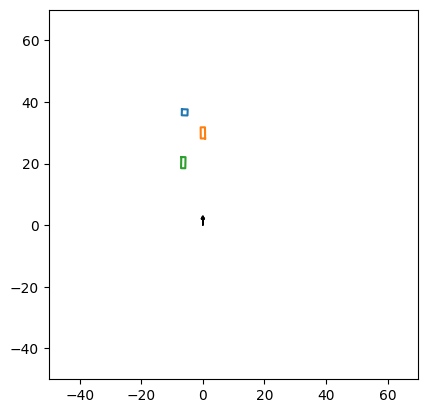

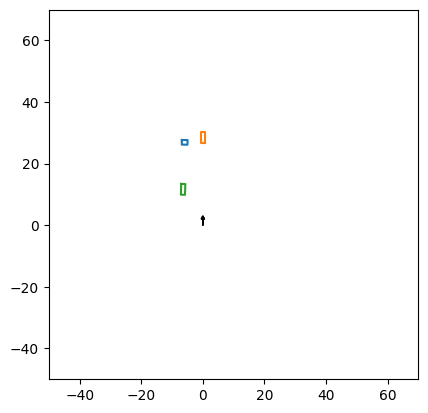

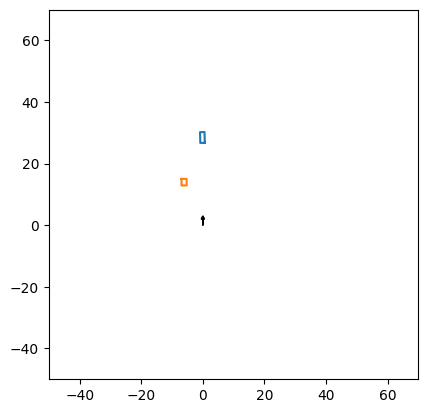

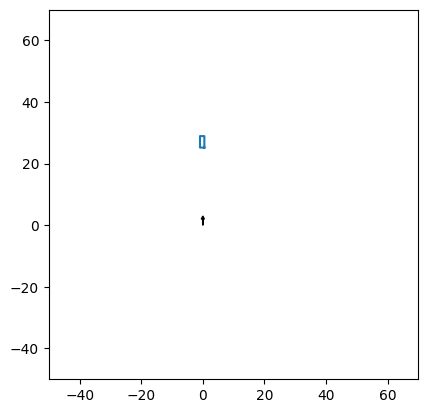

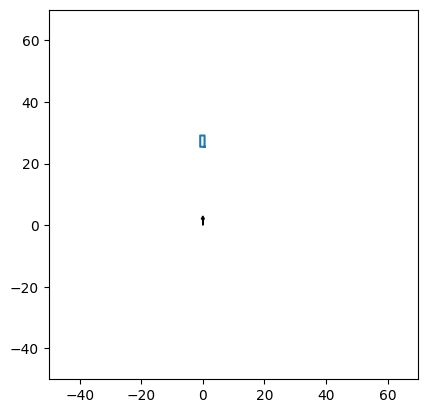

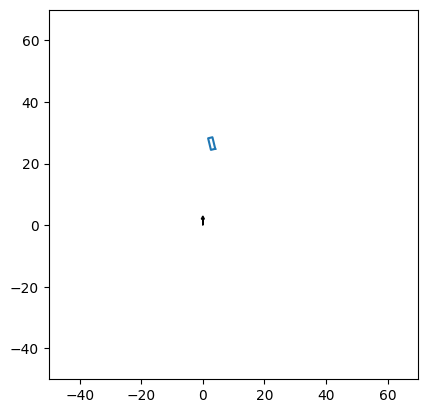

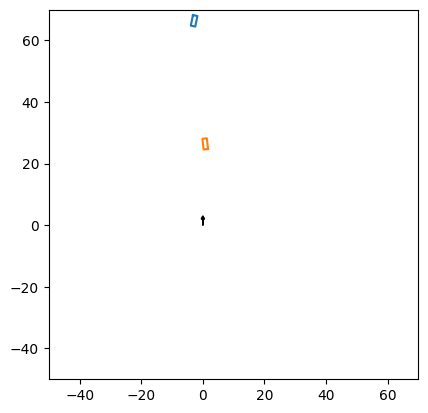

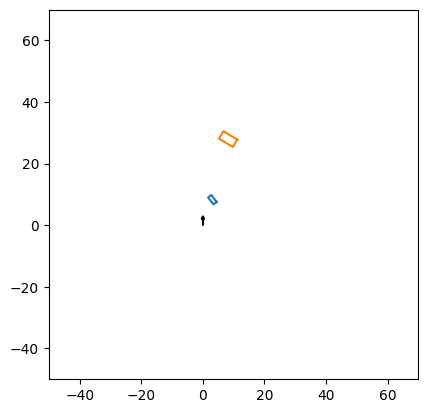

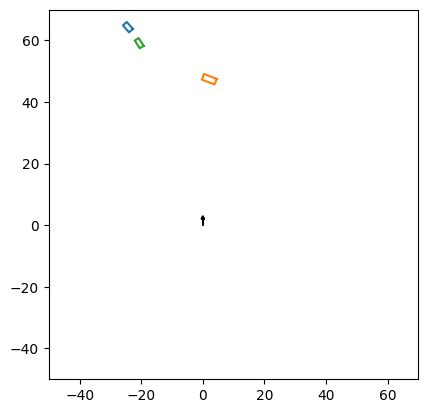

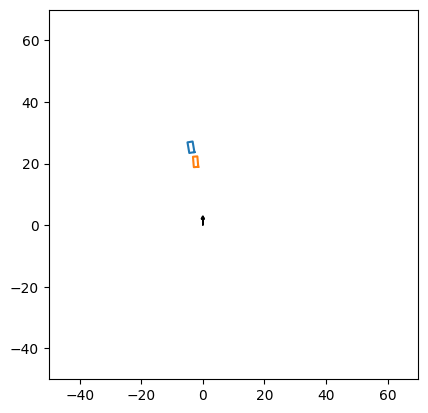

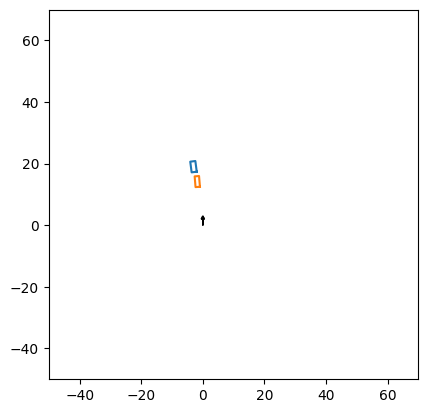

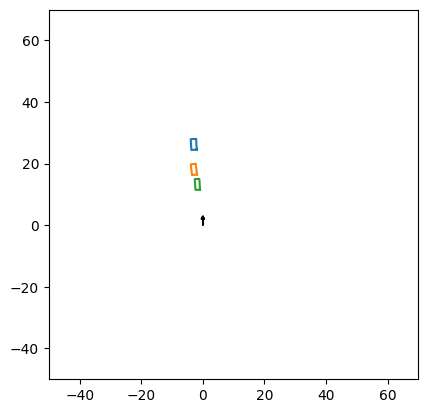

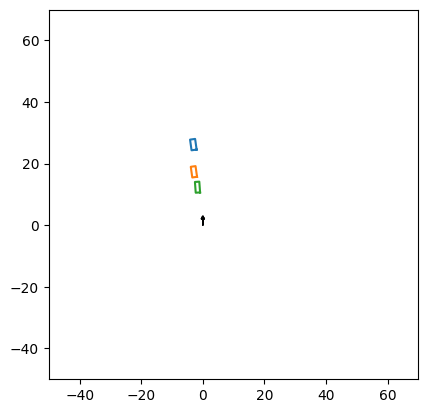

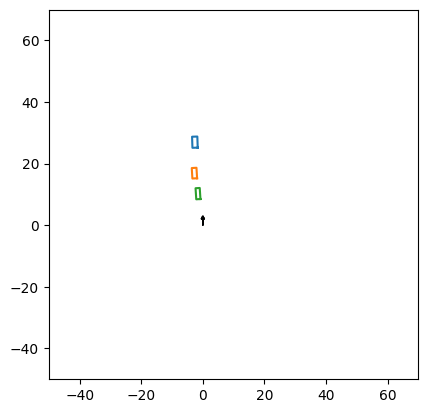

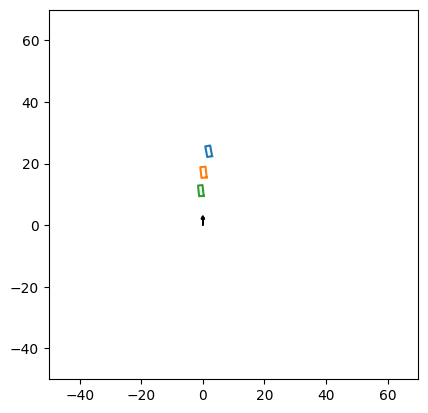

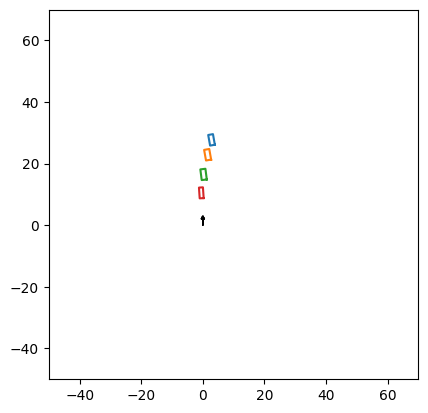

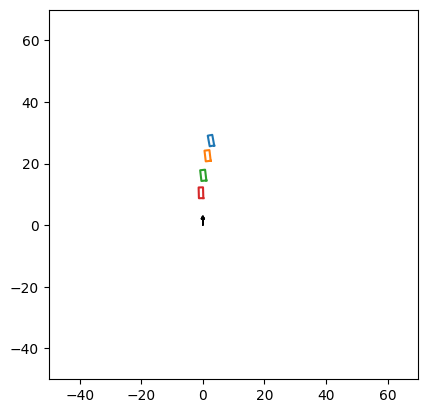

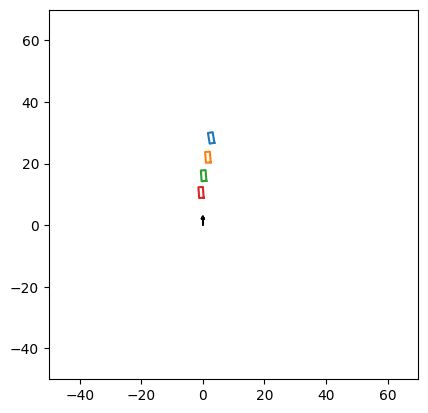

In [114]:
import matplotlib.pyplot as plt
for k in range(len(dataset)):
    print('k',k)
    imobjs = dataset[k]
    image= imobjs.image
    image1= np.swapaxes(image, 0,2)
    image2=  np.swapaxes(image1, 1,0)
    #print(image2.shape)
    image3= np.array(image2, dtype= 'uint8')
    gts = imobjs.gts
    #print(gts)
    #canvas= 200* np.ones((1000, 1000), dtype=np.uint8)
    #print(canvas.shape[0])
    fig= plt.figure()
    axis_bev =plt.gca() 
    
    for i in range(len(gts)):
        box=(gts[i]['bbox_full'])
        for j in range(len(box)):
            box[j]*= 0.25
        #draw_2d_box(image3,box)
        center_x=gts[i]['bbox_3d'][0] 
        center_y=gts[i]['bbox_3d'][1]
        pos = [center_x, center_y]
        for j in range(len(pos)):
            pos[j]*=0.25
        w3d= gts[i]['bbox_3d'][3] 
        h3d= gts[i]['bbox_3d'][4] 
        l3d= gts[i]['bbox_3d'][5] 
        rotY=gts[i]['bbox_3d'][6] 
        x3d= gts[i]['bbox_3d'][7] 
        y3d= gts[i]['bbox_3d'][8] 
        z3d= gts[i]['bbox_3d'][9] 
        verts= project_3d(imobjs.P, x3d, y3d, z3d, w3d, h3d, l3d, rotY, return_3d=False)
        draw_3d_box(image3, verts, color=(0, 200, 0), thickness=2)
        
        #draw_circle(image3, pos)
        axis_bev= draw_bev(axis_bev,y3d, l3d, w3d, x3d, rotY, color=(0, 200, 200), scale=1, thickness=3)
        
    axis_bev.set_xlim((-50, 70)) # set axis dimensions
    axis_bev.set_ylim((-50, 70)) # set axis dimensions
    axis_bev.set_aspect('equal', 'box')
    
    path= r"E:\Thesis_Final\Baseline\M3D-RPN\groundtruths\image_%d.png"%k
    bev_path=r"E:\Thesis_Final\Baseline\M3D-RPN\bev_groundtruths\image_%d.png"%k
    plt.savefig(bev_path, dpi=200)
    #canvas = cv2.rotate(canvas, cv2.ROTATE_90_COUNTERCLOCKWISE)
    #canvas= cv2.flip(canvas,1)
    cv2.imwrite(path, image3)
    #cv2.imwrite(bev_path, canvas)

In [98]:
bev_path=r"E:\Thesis_Final\Baseline\M3D-RPN\bev_groundtruths\image_%d.png"%k
for k in range(len(dataset)):
    bev_path=r"E:\Thesis_Final\Baseline\M3D-RPN\bev_groundtruths\image_%d.png"%k
    im= Image.open(bev_path)
    im= im.transpose(method=Image.FLIP_LEFT_RIGHT)
    im.save(bev_path)